<a href="https://colab.research.google.com/github/20toduc01/NekoNet/blob/main/Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Clone the repo and install dependencies

In [1]:
!rm -r NekoNet
!git clone https://github.com/20toduc01/NekoNet
%cd NekoNet
!pip install -r requirements.txt

rm: cannot remove 'NekoNet': No such file or directory
Cloning into 'NekoNet'...
remote: Enumerating objects: 692, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 692 (delta 4), reused 13 (delta 3), pack-reused 665
Receiving objects: 100% (692/692), 28.70 MiB | 29.41 MiB/s, done.
Resolving deltas: 100% (360/360), done.
/content/NekoNet
     |████████████████████████████████| 376 kB 8.7 MB/s 
     |████████████████████████████████| 4.5 MB 56.2 MB/s 
     |████████████████████████████████| 12.2 MB 35.9 MB/s 


In [2]:
import cv2, torch
from google.colab.patches import cv2_imshow
import numpy as np

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

Running on cuda


#### Importing the face detector and descriptor

In [4]:
from models.detectors import Yolov5Detector
detector = Yolov5Detector()

./models/yolov5.torchscript.pt not found, downloading from https://github.com/20toduc01/NekoNet/releases/download/v1.1/yolov5.torchscript.pt


In [5]:
from models.descriptors import EfficientNetV2B0_128
model = EfficientNetV2B0_128(pretrained=True)
model.to(device)
model = model.eval()

./models/efficientnetv2_b0_state.pt not found, downloading from https://github.com/20toduc01/NekoNet/releases/download/v1.1/effnetv2b0_128_state.pt


#### Face embeddings from an image

In [6]:
import torchvision.transforms as T
# Required transformation on 3xHxW RGB image before feeding to descriptor model
transform = T.Compose([T.Resize((224, 224)),
                       lambda x : x/255.0,
                       T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

In [7]:
## L2 distance
def L2(a, b):
  return torch.linalg.norm(a - b)

In [8]:
def extract_embedding(imgpath):
  embs = []
  frame = cv2.imread(imgpath)
  # Face detection in [(x1, y1, x2, y2, conf, cls), (...), ...] format
  detections = detector.detect(frame)
  if detections is None: return []
  for det in detections.int():
    x1 = det[0].item()
    x2 = det[2].item()
    y1 = det[1].item()
    y2 = det[3].item()
    # Cropped face
    face = frame[y1:y2, x1:x2, :]
    face = np.ascontiguousarray(face[:, :, ::-1].transpose(2, 0, 1)) # to 3xHxW, BGR to RGB
    # To tensor
    facetensor = torch.tensor(face, device=device)
    facetensor = transform(facetensor)
    topleft = (x1, y1)
    botright = (x2, y2)
    # Draw face recs on frame
    cv2.rectangle(frame, topleft, botright, (0, 0, 255), 4)
    # Feeding preprocessed face images to descriptor
    emb = model(torch.unsqueeze(facetensor, 0))
    embs.append(emb)
  cv2_imshow(frame)
  return embs

Let's test on an image

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)


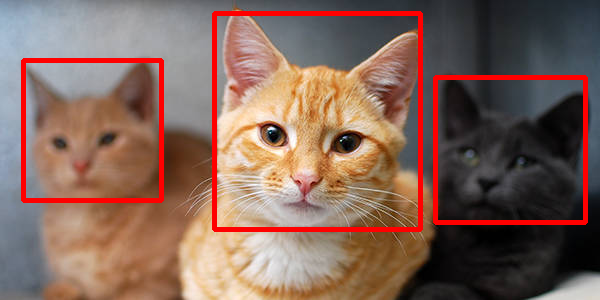

In [9]:
face = extract_embedding('./_static/cats.jpg')

#### Print distances between the faces. 

In [10]:
# Optimal classification threshold for this specific model is 1.1
print(L2(face[0], face[1]))
print(L2(face[0], face[2]))
print(L2(face[1], face[2]))

tensor(1.3314, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(1.3505, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(1.3211, device='cuda:0', grad_fn=<CopyBackwards>)
